In [57]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import RawDataset, ImbalancedDatasetSampler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

SEQUENCE_LENGTH = 56 # Analysis file at `maximum input_size`
SENTIMENT_CLASSES = 5 
CLASSES = ['negative', 'somewhat neg', 'neutral', 'somewhat pos', 'positive']

# Dataset

In [2]:
df = pd.read_csv('train.tsv', sep='\t')

In [3]:
df = df.drop(columns=['PhraseId', 'SentenceId'])

In [4]:
train, test = train_test_split(df, test_size=0.2)

In [5]:
len(train), len(test)

(124848, 31212)

In [9]:
df.iloc[17]

Phrase       what is good for the goose
Sentiment                             2
Name: 17, dtype: object

In [5]:
train_dataset = RawDataset(train)
test_dataset = RawDataset(test)

### Found bug when using ImbalancedDatasetSampler
DataLoader will randomly return me arbitrary `batch_size`. Therefore I have to use `batch_size=1` only

In [6]:
%%time
train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset))
test_loader = DataLoader(dataset=test_dataset, sampler=ImbalancedDatasetSampler(test_dataset))

CPU times: user 55.5 s, sys: 20 ms, total: 55.6 s
Wall time: 55.6 s


with open('train_loader.pkl', 'rb') as my_input:
    train_loader = pickle.load(my_input)
with open('test_loader.pkl', 'rb') as my_input2:
    test_loader = pickle.load(my_input2)

import pickle

with open('train_loader.pkl', 'wb') as output:
    pickle.dump(train_loader, output, pickle.HIGHEST_PROTOCOL)
with open('test_loader.pkl', 'wb') as output:
    pickle.dump(test_loader, output, pickle.HIGHEST_PROTOCOL)

for i, (data, target) in enumerate(train_loader):
    if i == 0:
        import ipdb; ipdb.set_trace()
        print(data)
        print(target)
        break

# Utilities

In [58]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    This function has one line different from the ordinary `train()` function
    It has `make_variables()` to convert tuple of names to be a tensor
    """
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

        # For some reason `train_loader` encapsulates my data with tuple
        data = [i[0] for i in data]
        data = [my_dict.word2idx[i] for i in data]
        
        # Do not forget to convert the tuple of string to a tensor
        data = torch.tensor([data], dtype=torch.long)

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        tmp = output.view(-1, SENTIMENT_CLASSES)
        
        loss = criterion(tmp, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = [i[0] for i in data]
            data = [my_dict.word2idx[i] for i in data]
            data = torch.tensor([data], dtype=torch.long)
            
            data, target = data.to(device), target.to(device)

            output = model(data)
            tmp = output.view(-1, SENTIMENT_CLASSES)

            test_loss += criterion(tmp, target).item() # sum up batch loss
            pred = tmp.max(1, keepdim=True)[1] # get the index of the max log-probability

            pred_tmp = pred.view(-1)
            pred_list = pred_tmp.tolist()
            target_list = target.tolist()
            
            y_test += target_list
            y_pred += pred_list
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=CLASSES, normalize=True,
                          title='Confusion matrix')


# 1. Model

In [50]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=56, hidden_size=256, output_size=5, n_layers=1):
        """
        Because word embedding is working with ascii. It has to use `input_size=256, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # input_size 256, hidden_size 256.
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        # Sung Kim run this all at once (over the whole input sequence)
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        
        # input: B x S -- (transpose) --> S x B
        input = input.t()
        
        # Embedding S x B -> S x B x I (embedding size)
        # print(f" input size: {input.size()}")
        embedded = self.embedding(input)
        embedded = embedded.clone().detach() # Make new tensor because of `EmbeddingGrad`
        # print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        output, hidden = self.gru(embedded, hidden)
        # print(f" gru hidden output: {hidden.size()}")
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        # print(f" fc output: {fc_output.size()}")
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach()

In [31]:
import pickle
from utils import Dictionary

with open('dictioanry_data.pkl', 'rb') as input:
    my_dict = pickle.load(input)

In [32]:
inputs = "what is good for the goose".split(' ')
inputs = [my_dict.word2idx[i] for i in inputs]
inputs = torch.tensor([inputs, inputs], dtype=torch.long)

In [33]:
inputs

tensor([[ 8,  9, 10, 11,  5, 12],
        [ 8,  9, 10, 11,  5, 12]])

In [16]:
model = RNNClassifier()

In [17]:
model(inputs)

> <ipython-input-9-e5bf5157dc93>(22)forward()
     21         # input = B x S . size(0) = B
---> 22         batch_size = input.size(0)
     23 

ipdb> input
tensor([[ 8,  9, 10, 11,  5, 12],
        [ 8,  9, 10, 11,  5, 12]])
ipdb> c


tensor([[[ 0.1265,  0.1642,  0.0881, -0.0199,  0.0541],
         [ 0.1265,  0.1642,  0.0881, -0.0199,  0.0541]]],
       grad_fn=<AddBackward0>)

In [41]:
def str2word_idx_arr(tokenized_sentence):
    """
    string to word-index and array
    """
    arr = [my_dict.word2idx[word] for word in tokenized_sentence]
    return arr, len(arr)

In [42]:
def pad_sequences(vectorized_seqs, seq_lengths):
    """
    Let the `SEQUENCE_LENGTH` is 19. According to the dataset
    """
    seq_tensor = torch.zeros((len(vectorized_seqs), SEQUENCE_LENGTH), dtype=torch.long)
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.tensor(seq, dtype=torch.long)
    return seq_tensor

In [43]:
def make_variables(sentence):
    sequence_and_length = [str2word_idx_arr(word) for word in sentence]
    vectorized_seqs = [sl[0] for sl in sequence_and_length]
    seq_lengths = torch.tensor([sl[1] for sl in sequence_and_length])
    return pad_sequences(vectorized_seqs, seq_lengths)

make_variables(['i my cat'.split(' '), 'what is good for the goose'.split(' ')])

tensor([[  41, 1828, 2336,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   8,    9,   10,   11,    5,   12,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

# 2. Criterion & Optimizer

In [44]:
input_size = len(my_dict.idx2word) #19479
input_size

19479

In [55]:
model = RNNClassifier(input_size=input_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



Test set: Average loss: 1.2903, Accuracy: 14810/31212 (47%)

[[3822 1096  495  469  222]
 [2031 1717 1378  892  323]
 [ 510  955 2895 1513  396]
 [ 376  544 1150 2362 1759]
 [ 199  135  276 1683 4014]]


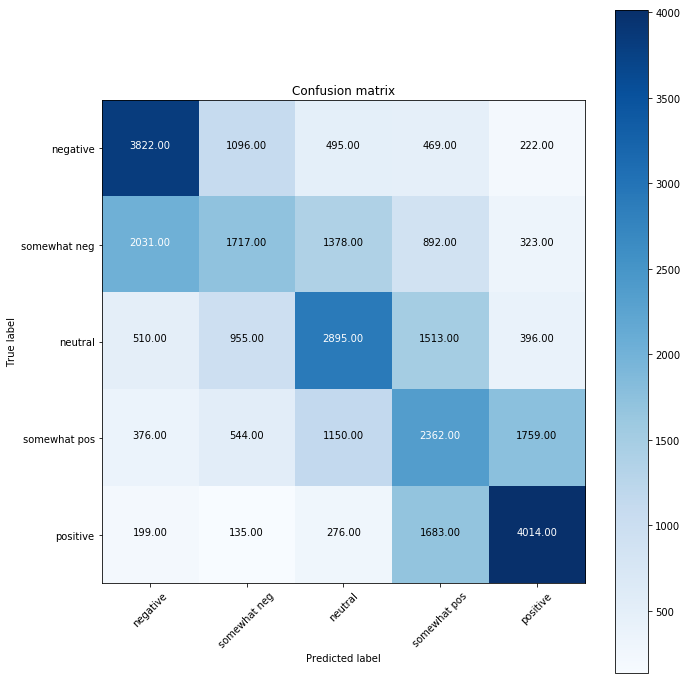

In [59]:
for epoch in range(1, 1 + 1):
#     train(model, 'cpu', train_loader, optimizer, epoch, criterion)
    test(model, 'cpu', test_loader, criterion)